### **Stellar classification**

In [ ]:
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=e991be32d36b408615ff06e5d9ba8922f9405edb0dd943e18e0f27622099d398
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from google.colab import drive
import itertools
from datetime import datetime, timedelta
from sklearn.preprocessing import QuantileTransformer
from imblearn.over_sampling import SMOTE
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql import functions as fn
from pyspark.sql.functions import col, udf, min, max, count, when, avg
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator




 Dataset is made up of 100,000 observations of space taken by the SDSS (Sloan Digital Sky Survey).

Each example is described by 17 feature columns and 1 class column which can be either a star, galaxy or quasar.
-	obj_ID: object Identifier, the ID that identifies the object
-	alpha: right ascension angle (at J2000 epoch)
-	delta: declination angle (at J2000 epoch)
-	u: ultraviolet filter value
-	g: green filter value
-	r: red filter value
- i: near infrared filter value
-	z: infrared filter value
-	run_ID: run number used to identify the specific scan
-	rereun_ID: rerun number used to specify how the image was processed
-	cam_col: camera column to identify the scanline within the run
-	field_ID: field number to identify each field
-	spec_obj_ID: unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
-	**Class**: object class (galaxy, star or quasar)
-	redshift: redshift value based on the increase in wavelength
-	plate: plate ID, identifies each plate in SDSS
-	MJD: modified julian date, used to indicate when a given piece of SDSS data was taken
-	fiber_ID: fiber ID that identifies the fiber that pointed the light at the focal plane in each observation


# Data preparation

In [ ]:
dataset_features = ['obj_ID','alpha','delta',
                    'u','g','r','i','z',
                    'run_ID','rerun_ID','cam_col','field_ID','spec_obj_ID',
                    'redshift','plate','MJD','fiber_ID']

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
spark = SparkSession.builder.appName('Star classification').getOrCreate()
spark

In [ ]:
path = "/content/drive/MyDrive/Big data/star_classification.csv"

data = spark.read.csv(path, header=True, inferSchema=True)
data.show()

+--------------------+----------------+------------------+--------+--------+--------+--------+--------+------+--------+-------+--------+--------------------+------+------------+-----+-----+--------+
|              obj_ID|           alpha|             delta|       u|       g|       r|       i|       z|run_ID|rerun_ID|cam_col|field_ID|         spec_obj_ID| class|    redshift|plate|  MJD|fiber_ID|
+--------------------+----------------+------------------+--------+--------+--------+--------+--------+------+--------+-------+--------+--------------------+------+------------+-----+-----+--------+
|1.237660961327743...|  135.6891066036|  32.4946318397087|23.87882| 22.2753|20.39501|19.16573|18.79371|  3606|     301|      2|      79|6.543777369295181...|GALAXY|   0.6347936| 5812|56354|     171|
|1.237664879951151...|144.826100550256|  31.2741848944939|24.77759|22.83188|22.58444|21.16812|21.61427|  4518|     301|      5|     119|1.176014203670733...|GALAXY|    0.779136|10445|58158|     427|
|1.23

In [ ]:
data.groupBy("class").count().show()

+------+-----+
| class|count|
+------+-----+
|GALAXY|59445|
|   QSO|18961|
|  STAR|21594|
+------+-----+



In [ ]:
type(data)

pyspark.sql.dataframe.DataFrame

# Data analysis

In [ ]:
pd.DataFrame(data.dtypes, columns = ['Column','Type'])

,Column,Type
0,obj_ID,double
1,alpha,double
2,delta,double
3,u,double
4,g,double
5,r,double
6,i,double
7,z,double
8,run_ID,int
9,rerun_ID,int


In [ ]:
# count null values
null_counts = data.agg(*[(fn.count(fn.when(col(column).isNull(), column))).alias(column) for column in data.columns])
null_counts.show()

+------+-----+-----+---+---+---+---+---+------+--------+-------+--------+-----------+-----+--------+-----+---+--------+
|obj_ID|alpha|delta|  u|  g|  r|  i|  z|run_ID|rerun_ID|cam_col|field_ID|spec_obj_ID|class|redshift|plate|MJD|fiber_ID|
+------+-----+-----+---+---+---+---+---+------+--------+-------+--------+-----------+-----+--------+-----+---+--------+
|     0|    0|    0|  0|  0|  0|  0|  0|     0|       0|      0|       0|          0|    0|       0|    0|  0|       0|
+------+-----+-----+---+---+---+---+---+------+--------+-------+--------+-----------+-----+--------+-----+---+--------+



In [ ]:
u_mean = data.groupBy('class').agg(avg('u').alias('ultraviolet_filter'))
g_mean = data.groupBy('class').agg(avg('g').alias('green_filter'))
r_mean = data.groupBy('class').agg(avg('r').alias('red_filter'))
redshift_mean = data.groupBy('class').agg(avg('redshift').alias('redshift_value'))

In [ ]:
redshift_mean.show()
u_mean.show()
g_mean.show()
r_mean.show()

+------+--------------------+
| class|      redshift_value|
+------+--------------------+
|GALAXY|  0.4215961504447538|
|   QSO|  1.7196760892911382|
|  STAR|-1.14897203275575...|
+------+--------------------+

+------+------------------+
| class|ultraviolet_filter|
+------+------------------+
|GALAXY| 22.58737929026834|
|   QSO| 21.54761927324517|
|  STAR| 20.68980531397607|
+------+------------------+

+------+------------------+
| class|      green_filter|
+------+------------------+
|GALAXY|20.906101454453566|
|   QSO| 20.92619299245825|
|  STAR|19.153188379642533|
+------+------------------+

+------+------------------+
| class|        red_filter|
+------+------------------+
|GALAXY|19.587551746488224|
|   QSO| 20.62408902431311|
|  STAR|18.946969021024398|
+------+------------------+



In [ ]:
u_mean_values = u_mean.select('ultraviolet_filter').rdd.flatMap(lambda x: x).collect()
g_mean_values = g_mean.select('green_filter').rdd.flatMap(lambda x: x).collect()
r_mean_values = r_mean.select('red_filter').rdd.flatMap(lambda x: x).collect()
redshift_values = redshift_mean.select('redshift_value').rdd.flatMap(lambda x: x).collect()

In [ ]:
classes = ['Galaxy', 'Qso', 'Star']

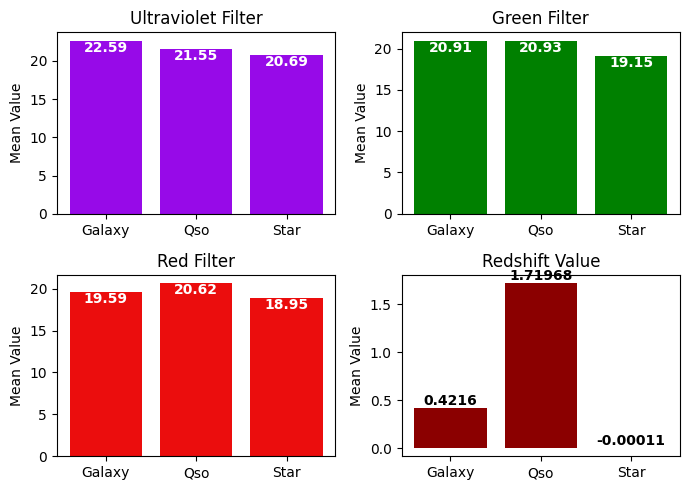

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(7, 5))

# Ultraviolet Filter
axs[0, 0].bar(classes, u_mean_values, color='#970AE8')
axs[0, 0].set_title('Ultraviolet Filter')
axs[0, 0].set_ylabel('Mean Value')
for i in range(len(classes)):
    axs[0, 0].text(classes[i], u_mean_values[i], round(u_mean_values[i], 2), fontsize=10, color='white',fontweight='bold', ha='center', va='top')

# Green Filter
axs[0, 1].bar(classes, g_mean_values, color='green')
axs[0, 1].set_title('Green Filter')
axs[0, 1].set_ylabel('Mean Value')
for i in range(len(classes)):
    axs[0, 1].text(classes[i], g_mean_values[i], round(g_mean_values[i], 2), fontsize=10, color='white', fontweight='bold',ha='center', va='top')

# Red Filter
axs[1, 0].bar(classes, r_mean_values, color='#EB0D0D')
axs[1, 0].set_title('Red Filter')
axs[1, 0].set_ylabel('Mean Value')
for i in range(len(classes)):
    axs[1, 0].text(classes[i], r_mean_values[i], round(r_mean_values[i], 2), fontsize=10, color='white',fontweight='bold', ha='center', va='top')

# Redshift Value
axs[1, 1].bar(classes, redshift_values, color='#8B0000')
axs[1, 1].set_title('Redshift Value')
axs[1, 1].set_ylabel('Mean Value')
for i in range(len(classes)):
    axs[1, 1].text(classes[i], redshift_values[i], round(redshift_values[i], 5), fontsize=10, color='black',fontweight='bold', ha='center', va='bottom')

plt.tight_layout()
plt.show()


The **MJD** column of this dataset describes in what particulare date a stellar object has been taken by the SDSS17.

The MJD (modified julian date) gives the number of days since midnight on November 17, 1858.
This date corresponds to 2400000.5 days after day 0 of the Julian calendar. It's a unit of measurement used by astronomers.

This dataset has date in MJD, so i wrote a function to convert data in julian date.

In [ ]:
def convert_to_julian_date(mjd):

  # data reference for this unit of measurement
  start_date = datetime(1858, 11, 17)

  date = start_date + timedelta(days=mjd)
  return date.strftime("%Y-%m-%d")

In [ ]:
convert_to_julian_date(55864)

'2011-10-30'

In [ ]:
convert_mjd_to_date_udf = udf(convert_to_julian_date, StringType())

# Apply the UDF to the DataFrame to convert all rows
converted_df = data.withColumn("date", convert_mjd_to_date_udf(data["mjd"]))
date_df = converted_df.select("date")

In [ ]:
min_date = date_df.select(min("date")).first()[0]
max_date = date_df.select(max("date")).first()[0]

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)

Minimum Date: 2000-03-05
Maximum Date: 2020-03-24


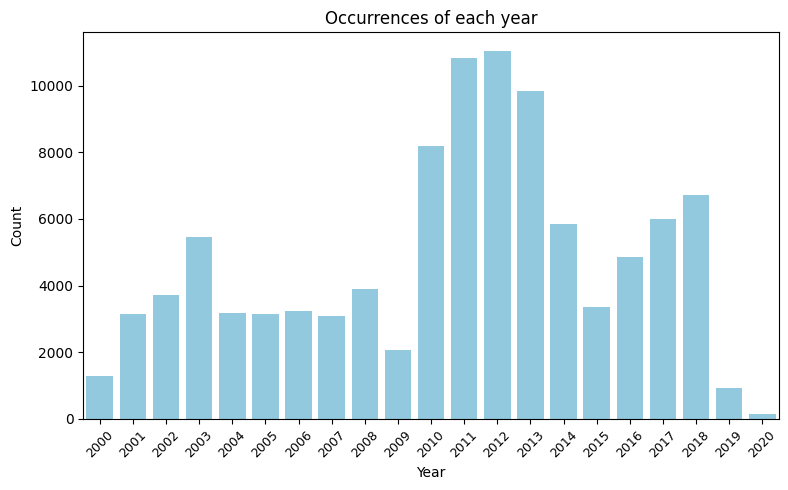

In [ ]:
# Extracting year from the date column
date_df = date_df.withColumn('year', date_df['date'].substr(1, 4))

# Group the data by year and count the occurrences
date_counts_df = date_df.groupBy("year").agg(count("*").alias("count")).orderBy("year")

# Convert the dataframe to pandas for plotting
date_counts_pd = date_counts_df.toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(x="year", y="count", data=date_counts_pd, color='skyblue')
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(fontsize=9, rotation=45)
plt.title("Occurrences of each year")
plt.tight_layout()
plt.show()

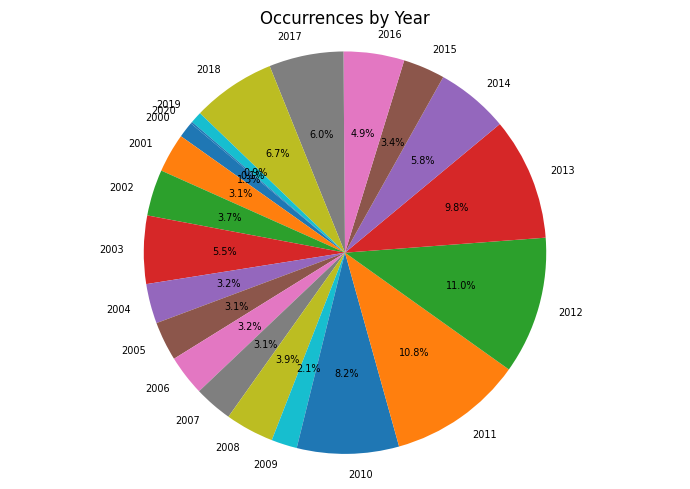

In [ ]:
year_counts_df = date_df.groupBy(date_df['date'].substr(1, 4).alias("year")).count().orderBy("year")

year_counts_pd = year_counts_df.toPandas()

plt.figure(figsize=(7, 5))
plt.pie(year_counts_pd['count'], labels=year_counts_pd['year'], autopct='%1.1f%%', startangle=140, textprops={'fontsize': 7})
plt.title("Occurrences by Year")
plt.axis('equal')
plt.tight_layout()
plt.show()

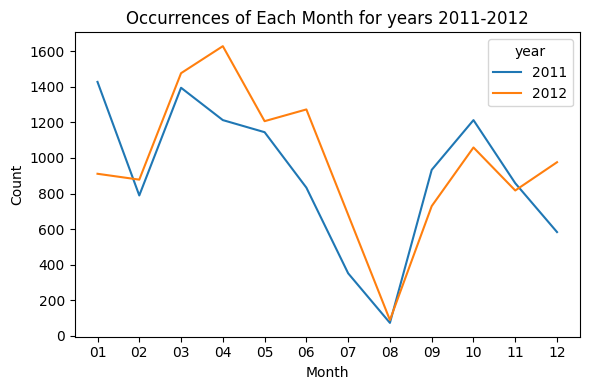

In [ ]:
# Print for 2011 and 2012 (the years with most occurrences) the month in which most object have been discovered

filtered_df = date_df.filter((date_df['date'] >= '2011-01-01') & (date_df['date'] <= '2012-12-31'))
filtered_df = filtered_df.withColumn('year', filtered_df['date'].substr(1, 4))
filtered_df = filtered_df.withColumn('month', filtered_df['date'].substr(6, 2))

date_counts_df = filtered_df.groupBy("year", "month").agg(count("*").alias("count")).orderBy("year", "month")
date_counts_pd = date_counts_df.toPandas()

# Plot the result as a line plot
plt.figure(figsize=(6, 4))
sns.lineplot(x="month", y="count", hue="year", data=date_counts_pd, markers=False)  # Line plot without markers
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Occurrences of Each Month for years 2011-2012")
plt.tight_layout()
plt.show()

In [ ]:
#TODO

In [ ]:
date_counts_df.createOrReplaceTempView("data_view")

query = """
SELECT year, month, count
FROM (
    SELECT year, month, count,
           ROW_NUMBER() OVER (PARTITION BY year ORDER BY count DESC) as rank
    FROM data_view
)
WHERE rank = 1
"""

result = spark.sql(query)
result.show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2011|   01| 1428|
|2012|   04| 1629|
+----+-----+-----+



In [ ]:
query = """
SELECT year, month, count
FROM (
    SELECT year, month, count,
           ROW_NUMBER() OVER (PARTITION BY year ORDER BY count ASC) as rank
    FROM data_view
)
WHERE rank = 1
"""

result = spark.sql(query)
result.show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2011|   08|   72|
|2012|   08|   88|
+----+-----+-----+



In [ ]:
query = """
SELECT year, SUM(count) AS total
FROM data_view
GROUP BY year
ORDER BY year;
"""

result = spark.sql(query)
result.show()

+----+-----+
|year|total|
+----+-----+
|2011|10813|
|2012|11044|
+----+-----+



# Features engineering



In [ ]:
def hist_plot(dataset):
  plt.figure(figsize=(2, 2))
  plt.hist(dataset, bins=30, color='skyblue', edgecolor='black')
  plt.title('data distribution')
  plt.xlabel('value')
  plt.ylabel('frequency')
  plt.grid(True)
  plt.show()

Feature scaling

In [ ]:
features_to_scale = ['u', 'z', 'i', 'r', 'g', 'redshift','alpha','delta']

In [ ]:
scaler = QuantileTransformer(output_distribution='normal')

X_scaled = data.toPandas()

scaler.fit(X_scaled[features_to_scale])
X_scaled[features_to_scale] = scaler.transform(X_scaled[features_to_scale])
X_scaled.head(5)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,-0.521439,0.316868,0.765268,0.781841,0.172245,-0.132194,-0.126063,3606,301,2,79,6.543777e+18,GALAXY,0.540235,5812,56354,171
1,1.237665e+18,-0.390811,0.280785,1.140543,1.238373,2.146540,1.239472,1.783536,4518,301,5,119,1.176014e+19,GALAXY,0.768207,10445,58158,427
2,1.237661e+18,-0.428785,0.460647,1.377922,1.094397,0.335867,-0.032297,-0.039904,3606,301,2,120,5.152200e+18,GALAXY,0.561274,4576,55592,299
3,1.237663e+18,1.424004,-1.217670,-0.009315,1.857214,1.137861,0.762231,0.183351,4192,301,3,214,1.030107e+19,GALAXY,0.940001,9149,58039,775
4,1.237680e+18,1.542614,-0.080340,-1.087690,-1.390482,-1.602826,-1.612500,-1.809780,8102,301,3,137,6.891865e+18,GALAXY,-0.485642,6121,56187,842


In [ ]:
from pyspark.sql.functions import col

feat_scaled = data.select(features_to_scale)
all_columns = data.columns
feat_not_scaled = [col_name for col_name in all_columns if col_name not in features_to_scale]

In [ ]:
from pyspark.ml.feature import MaxAbsScaler

# Assembla tutte le colonne in un unico vettore
assembler = VectorAssembler(inputCols=features_to_scale, outputCol="features")
df_vector = assembler.transform(data)

# Applica AbsMaxScaler
scaler = MaxAbsScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_vector)
scaled_df = scaler_model.transform(df_vector)

In [ ]:
scaled_df

DataFrame[obj_ID: double, alpha: double, delta: double, u: double, g: double, r: double, i: double, z: double, run_ID: int, rerun_ID: int, cam_col: int, field_ID: int, spec_obj_ID: double, class: string, redshift: double, plate: int, MJD: int, fiber_ID: int, features: vector, scaled_features: vector]

In [ ]:
data_pd = data.toPandas()

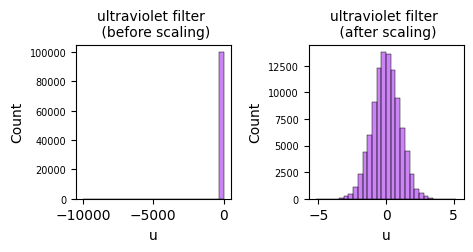

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(5, 2), gridspec_kw={'wspace': 0.5})

sns.histplot(data=data_pd, x='u', bins=30, alpha=0.5, ax=axes[0], color='#970AE8')
axes[0].set_title('ultraviolet filter \n (before scaling)', fontsize=10)
axes[0].tick_params(axis='y', labelsize=7)  # Set y-axis tick label font size

sns.histplot(data=X_scaled, x='u', bins=30, alpha=0.5, ax=axes[1], color='#970AE8')
axes[1].set_title('ultraviolet filter \n (after scaling)', fontsize=10)
axes[1].tick_params(axis='y', labelsize=7)  # Set y-axis tick label font size


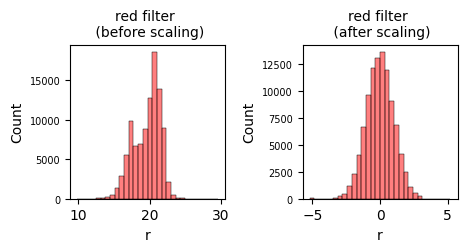

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(5, 2), gridspec_kw={'wspace': 0.5})

sns.histplot(data=data_pd, x='r', bins=30, alpha=0.5, ax=axes[0], color='red')
axes[0].set_title('red filter \n (before scaling)', fontsize=10)
axes[0].tick_params(axis='y', labelsize=7)  # Set y-axis tick label font size

sns.histplot(data=X_scaled, x='r', bins=30, alpha=0.5, ax=axes[1], color='red')
axes[1].set_title('red filter \n (after scaling)', fontsize=10)
axes[1].tick_params(axis='y', labelsize=7)  # Set y-axis tick label font size

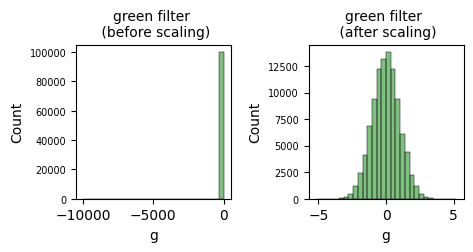

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(5, 2), gridspec_kw={'wspace': 0.5})

sns.histplot(data=data_pd, x='g', bins=30, alpha=0.5, ax=axes[0], color='green')
axes[0].set_title('green filter \n (before scaling)', fontsize=10)
axes[0].tick_params(axis='y', labelsize=7)  # Set y-axis tick label font size

sns.histplot(data=X_scaled, x='g', bins=30, alpha=0.5, ax=axes[1], color='green')
axes[1].set_title('green filter \n (after scaling)', fontsize=10)
axes[1].tick_params(axis='y', labelsize=7)  # Set y-axis tick label font size

In [ ]:
X_scaled = spark.createDataFrame(X_scaled)

Feature correlation

In [ ]:
assembler = VectorAssembler(inputCols=dataset_features, outputCol="features")
assembled_df = assembler.transform(X_scaled)

In [ ]:
# Compute correlation matrix
corr_matrix = Correlation.corr(assembled_df, "features", "spearman").collect()[0][0]
corr_df = pd.DataFrame(corr_matrix.toArray(), columns=dataset_features, index=dataset_features)

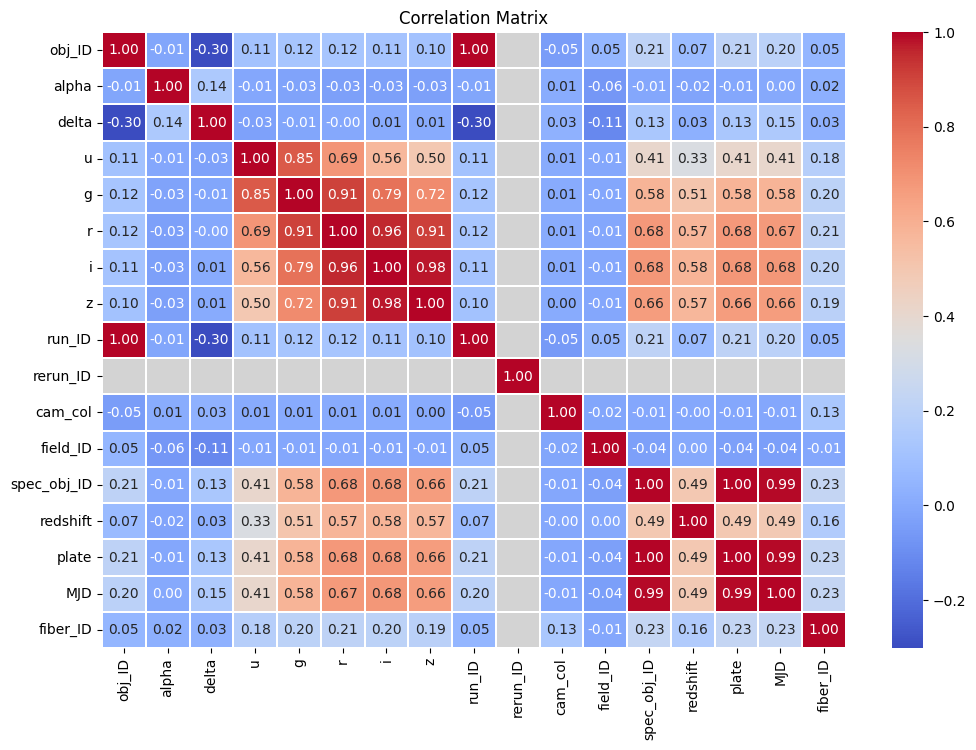

In [ ]:
mask = corr_df.isnull()
corr_df.index, corr_df.columns = dataset_features, dataset_features

plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.1)
plt.gca().patch.set_facecolor('lightgrey')

plt.title("Correlation Matrix")
plt.show()

In [ ]:
threshold_correlation = 0.5

# Find pairs of features with correlation above the threshold
correlation_pairs = {(pair, abs(corr_df.loc[pair])) for pair in itertools.combinations(corr_df.columns, 2)}
threshold_features_set_list = [pair[0] for pair in correlation_pairs if pair[1] > threshold_correlation]

# Flatten the list of sets to obtain the threshold features
threshold_features = list(set(itertools.chain.from_iterable(threshold_features_set_list)))
threshold_features.append('class')

selected_df = X_scaled.select(threshold_features)


selected_df = selected_df.withColumn('class',
                                     when(selected_df['class'] == 'GALAXY', 0)
                                    .when(selected_df['class'] == 'QSO', 1)
                                    .when(selected_df['class'] == 'STAR', 2)
                                    .otherwise(selected_df['class'].cast('int')))

# Select the threshold features and class column
selected_df = selected_df.select(threshold_features)
selected_df.show()

+------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+-----+
|run_ID|              obj_ID|                   g|plate|            redshift|                   i|                   z|                   r|         spec_obj_ID|  MJD|                   u|class|
+------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+-----+
|  3606|1.237660961327743...|  0.7818406632540335| 5812|  0.5402347925323866| -0.1321935470945311|-0.12606263910021273|  0.1722447193835865|6.543777369295181...|56354|  0.7652680831013237|    0|
|  4518|1.237664879951151...|  1.2383731017089796|10445|  0.7682072773858968|  1.2394717310218244|  1.7835363502709844|  2.1465404277702467|1.176014203670733...|58158|  1.1405427924503075|    0|
|  3606|1.237660961330430

In [ ]:
selected_df

DataFrame[run_ID: bigint, obj_ID: double, g: double, plate: bigint, redshift: double, i: double, z: double, r: double, spec_obj_ID: double, MJD: bigint, u: double, class: int]

# Data balancing

In [ ]:
ratio = 1

galaxy_count = selected_df.filter(fn.col('class') == 0).count()
qso_count = selected_df.filter(fn.col('class') == 1).count()
star_count = selected_df.filter(fn.col('class') == 2).count()

# Oversample of class 1
balance_ratio_qso = galaxy_count / qso_count
oversampled_qso = selected_df.filter(fn.col('class') == 1)\
                            .sample(withReplacement=True, fraction=(balance_ratio_qso / ratio), seed=88)

oversampled_df = selected_df.filter(fn.col('class') == 0).union(oversampled_qso)

# Oversample of class 2
balance_ratio_star = galaxy_count / star_count
oversampled_star = selected_df.filter(fn.col('class') == 2)\
                             .sample(withReplacement=True, fraction=(balance_ratio_star / ratio), seed=88)

oversampled_df = oversampled_df.union(oversampled_star)
oversampled_df.groupBy('class').count().show()

+-----+-----+
|class|count|
+-----+-----+
|    0|59445|
|    1|59495|
|    2|59341|
+-----+-----+




# Data preparation for traning phase

In [ ]:
feature_columns = oversampled_df.columns[:-1]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
transformed_df = assembler.transform(oversampled_df)

transformed_df = transformed_df.withColumnRenamed("target_variable_column", "class")
transformed_df = transformed_df.select("features", "class")
transformed_df.show()

+--------------------+-----+
|            features|class|
+--------------------+-----+
|[3606.0,1.2376609...|    0|
|[4518.0,1.2376648...|    0|
|[3606.0,1.2376609...|    0|
|[4192.0,1.2376634...|    0|
|[8102.0,1.2376802...|    0|
|[7773.0,1.2376788...|    0|
|[3716.0,1.2376614...|    0|
|[8102.0,1.2376802...|    0|
|[3927.0,1.2376623...|    0|
|[7773.0,1.2376788...|    0|
|[4192.0,1.2376634...|    0|
|[3927.0,1.2376623...|    0|
|[1412.0,1.2376515...|    0|
|[1412.0,1.2376515...|    0|
|[2821.0,1.2376575...|    0|
|[3927.0,1.2376623...|    0|
|[3015.0,1.2376584...|    0|
|[3015.0,1.2376584...|    0|
|[3015.0,1.2376584...|    0|
|[4192.0,1.2376634...|    0|
+--------------------+-----+
only showing top 20 rows



In [ ]:
transformed_df.show()

+--------------------+-----+
|            features|class|
+--------------------+-----+
|[3606.0,1.2376609...|    0|
|[4518.0,1.2376648...|    0|
|[3606.0,1.2376609...|    0|
|[4192.0,1.2376634...|    0|
|[8102.0,1.2376802...|    0|
|[7773.0,1.2376788...|    0|
|[3716.0,1.2376614...|    0|
|[8102.0,1.2376802...|    0|
|[3927.0,1.2376623...|    0|
|[7773.0,1.2376788...|    0|
|[4192.0,1.2376634...|    0|
|[3927.0,1.2376623...|    0|
|[1412.0,1.2376515...|    0|
|[1412.0,1.2376515...|    0|
|[2821.0,1.2376575...|    0|
|[3927.0,1.2376623...|    0|
|[3015.0,1.2376584...|    0|
|[3015.0,1.2376584...|    0|
|[3015.0,1.2376584...|    0|
|[4192.0,1.2376634...|    0|
+--------------------+-----+
only showing top 20 rows



In [ ]:
train_data, test_data = transformed_df.randomSplit([0.8, 0.2], seed=0)

# Training and test

In [ ]:
def eval_results(pred):
  # Accuracy
  evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
  accuracy = evaluator.evaluate(predictions)

  # Precision
  evaluator.setMetricName("weightedPrecision")
  precision = evaluator.evaluate(predictions)

  # Recall
  evaluator.setMetricName("weightedRecall")
  recall = evaluator.evaluate(predictions)

  #F1
  f1_score = 2 * (precision * recall) / (precision + recall)
  return accuracy, precision, recall, f1_score


# Decision tree classifier

Implemented using DecisionTreeClassifier from the pyspark library

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="class", featuresCol="features")


param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [16, 32, 64]) \
    .build()


evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")

# Set up cross-validation
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)  # Use 3 folds for cross-validation

# Perform hyperparameter tuning
cv_model = crossval.fit(train_data)

# Get the best model
best_model = cv_model.bestModel

# Make predictions on the test data using the best model
predictions = best_model.transform(test_data)

acc, prec, rec, f1 = eval_results(predictions)
print("Evaluation results:")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")

Evaluation results:
Accuracy:  0.980
Precision: 0.980
Recall:    0.980
F1 Score:  0.980


In [ ]:
best_model

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_14a5d49ab6b0, depth=15, numNodes=3289, numClasses=3, numFeatures=11

In [ ]:
best_params = {param[0].name: param[1] for param in best_model.extractParamMap().items()}

best_params

{'cacheNodeIds': False,
 'checkpointInterval': 10,
 'featuresCol': 'features',
 'impurity': 'gini',
 'labelCol': 'class',
 'leafCol': '',
 'maxBins': 64,
 'maxDepth': 15,
 'maxMemoryInMB': 256,
 'minInfoGain': 0.0,
 'minInstancesPerNode': 1,
 'minWeightFractionPerNode': 0.0,
 'predictionCol': 'prediction',
 'probabilityCol': 'probability',
 'rawPredictionCol': 'rawPrediction',
 'seed': 4061474480887984193}

# Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features",labelCol="class", numTrees=10, maxDepth=5, seed=42)
rfModel = rf.fit(train_data)

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

cross_validator = CrossValidator(estimator=rf,
      estimatorParamMaps=paramGrid,
      evaluator=MulticlassClassificationEvaluator(labelCol="class", metricName="accuracy"),
      numFolds=5, seed=42)

In [ ]:
cv_model = cross_validator.fit(train_data)
best_rf_model = cv_model.bestModel

In [ ]:
print("numTrees:", best_rf_model.getOrDefault("numTrees"))
print("maxDepth:", best_rf_model.getOrDefault("maxDepth"))

numTrees: 20
maxDepth: 15


In [ ]:
predictions = rfModel.transform(test_data)

acc, prec, rec, f1 = eval_results(predictions)
print("Evaluation results:")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")

Evaluation results:
Accuracy:  0.957
Precision: 0.957
Recall:    0.957
F1 Score:  0.957


In [ ]:
best_params = {param[0].name: param[1] for param in best_rf_model.extractParamMap().items()}
best_params

{'bootstrap': True,
 'cacheNodeIds': False,
 'checkpointInterval': 10,
 'featureSubsetStrategy': 'auto',
 'featuresCol': 'features',
 'impurity': 'gini',
 'labelCol': 'class',
 'leafCol': '',
 'maxBins': 32,
 'maxDepth': 15,
 'maxMemoryInMB': 256,
 'minInfoGain': 0.0,
 'minInstancesPerNode': 1,
 'minWeightFractionPerNode': 0.0,
 'numTrees': 20,
 'predictionCol': 'prediction',
 'probabilityCol': 'probability',
 'rawPredictionCol': 'rawPrediction',
 'seed': 42,
 'subsamplingRate': 1.0}

# Logistic multinomial regression



In [ ]:
train_data = train_data.withColumnRenamed("class", "label")
test_data = test_data.withColumnRenamed("class", "label")


In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label",
                        maxIter=10, regParam=0.2, elasticNetParam=0.8, family="multinomial")

# Define your parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.2, 0.3]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [5, 10, 20]) \
    .build()

# Define your evaluator
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# Define the CrossValidator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Run cross-validation, and choose the best set of parameters
cvModel = crossval.fit(train_data)

# Get the best model from cross-validation
best_model = cvModel.bestModel

In [ ]:
print("regParam:", best_model.getOrDefault("regParam"))
print("elasticNetParam:", best_model.getOrDefault("elasticNetParam"))
print("iter:", best_model.getOrDefault("maxIter"))

regParam: 0.1
elasticNetParam: 0.5
iter: 5


In [ ]:
best_params = {param[0].name: param[1] for param in best_model.extractParamMap().items()}
best_params

{'aggregationDepth': 2,
 'elasticNetParam': 0.5,
 'family': 'multinomial',
 'featuresCol': 'features',
 'fitIntercept': True,
 'labelCol': 'label',
 'maxBlockSizeInMB': 0.0,
 'maxIter': 5,
 'predictionCol': 'prediction',
 'probabilityCol': 'probability',
 'rawPredictionCol': 'rawPrediction',
 'regParam': 0.1,
 'standardization': True,
 'threshold': 0.5,
 'tol': 1e-06}

In [ ]:
test_data = test_data.withColumnRenamed("label", "class")

predictions = best_model.transform(test_data)

acc, prec, rec, f1 = eval_results(predictions)
print("Evaluation results:")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")


Evaluation results:
Accuracy:  0.883
Precision: 0.885
Recall:    0.883
F1 Score:  0.884


In [ ]:
spark.stop()